In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor,DMatrix,plot_tree

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [2]:
train_df = pd.read_csv('train_df_final.csv')
train_df = train_df.fillna(0)
train_df_org = pd.read_csv('train_df_final_blanced.csv')
train_df_org = train_df_org.fillna(0)
test_df = pd.read_csv('test_df_final.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
y = train_df['label'].values
y_org = train_df_org['label'].values

In [4]:
model_predictions_train = pd.DataFrame()
model_predictions_train['label'] = train_df['label']
model_predictions_org = pd.DataFrame()
model_predictions_org['label'] = y_org
model_predictions_test = pd.DataFrame()

## Anomaly based

In [5]:
features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

cat_features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

In [6]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [7]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='micro'), True

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred),average='micro')
    return 'f1_err', err

### catboost

In [8]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
}

In [9]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [10]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9532710	test: 0.9525581	best: 0.9525581 (0)	total: 53.5ms	remaining: 53.4s
10:	learn: 0.9532762	test: 0.9531481	best: 0.9535810 (1)	total: 108ms	remaining: 9.7s
20:	learn: 0.9537179	test: 0.9533160	best: 0.9535810 (1)	total: 156ms	remaining: 7.28s
30:	learn: 0.9545096	test: 0.9534754	best: 0.9535810 (1)	total: 210ms	remaining: 6.55s
40:	learn: 0.9552059	test: 0.9537862	best: 0.9538747 (35)	total: 260ms	remaining: 6.07s
50:	learn: 0.9556051	test: 0.9540347	best: 0.9540433 (45)	total: 310ms	remaining: 5.78s
60:	learn: 0.9557341	test: 0.9540176	best: 0.9541148 (55)	total: 363ms	remaining: 5.59s
70:	learn: 0.9559561	test: 0.9542836	best: 0.9542836 (70)	total: 436ms	remaining: 5.71s
80:	learn: 0.9559883	test: 0.9544525	best: 0.9544610 (78)	total: 506ms	remaining: 5.74s
90:	learn: 0.9561983	test: 0.9547103	best: 0.9547103 (88)	total: 563ms	remaining: 5.62s
100:	learn: 0.9563843	test: 0.9546131	best: 0.9548075 (92)	total: 606ms	remaining: 5.4s
110:	le

In [11]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9138915985194579, 0.00109574406471837, 0.9126436781609195)

In [12]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8936925527219696, 0.0019181392742079796, 0.8916585113119566)

In [13]:
name = 'catboost_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## LightGBM

In [14]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [15]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores =[]
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))

In [16]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9142452574169884, 0.000768615433601861, 0.9135278514588859)

In [17]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.895688215992171, 0.0004700342990776262, 0.8951125438949974)

In [18]:
name = 'lgb_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## K-NN

In [19]:
knn_params = {
    'n_neighbors':15,
    'weights':'uniform'    
}

In [20]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [21]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9117108878375522, 0.001250383548715244, 0.9103448275862069)

In [22]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8921382380596014, 0.0003527867578311166, 0.891716078521674)

In [23]:
name = 'knn_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Random forests

In [24]:
rf_params = {
    'n_estimators':50,
    'max_depth':10,
    'random_state':0,    
}

In [25]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [26]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9125361058273315, 7.606512654814278e-05, 0.9124823196605375)

In [27]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8968587492564235, 0.0005646936069526574, 0.8961487536699096)

In [28]:
name = 'rf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## SVC

In [29]:
svc_params = {
    'C':2,
    'kernel':'linear',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [30]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [31]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9112394746484881, 0.0008026435619151851, 0.9101838755304101)

In [32]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.8900466294398711, 1.1102230246251565e-16, 0.890046629439871)

In [33]:
name = 'svc_linear_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

In [34]:
svc_params = {
    'C':2,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [35]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [36]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9135969470383948, 0.0012302422268772803, 0.9124823196605375)

In [37]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.896628480417554, 0.00019569088379446943, 0.8964365897184964)

In [38]:
name = 'svc_rbf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Base features

In [39]:
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'fare',
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference',
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare',
    'fare-additional_fare-meter_waiting_fare',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',
    'fare_per_distance_mean',
    'fare_per_distance_mean_diff',
    'avg_speed_mean',
    'avg_speed_mean_diff',
    'meter_waiting_per_duration_mean',
    'meter_waiting_per_duration_mean_diff',
    'meter_waiting_fare_per_meter_waiting_mean',
    'meter_waiting_fare_per_meter_waiting_mean_diff',
    'meter_waiting_fare_per_duration_mean',
    'meter_waiting_fare_per_duration_mean_diff',
    'addtional_fare_per_fare_mean',
    'addtional_fare_per_fare_mean_diff',
    'addtional_fare_per_distance_mean',
    'addtional_fare_per_distance_mean_diff',
    'addtional_fare_per_duration_mean',
    'addtional_fare_per_duration_mean_diff',
]

cat_features = [
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
]

In [40]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

### Catboost

In [41]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [42]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [43]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9648677	test: 0.9632484	best: 0.9632484 (0)	total: 23.9ms	remaining: 23.8s
10:	learn: 0.9698117	test: 0.9702933	best: 0.9713853 (3)	total: 260ms	remaining: 23.4s
20:	learn: 0.9724266	test: 0.9752664	best: 0.9761112 (19)	total: 473ms	remaining: 22s
30:	learn: 0.9747203	test: 0.9771925	best: 0.9774895 (28)	total: 728ms	remaining: 22.8s
40:	learn: 0.9764801	test: 0.9775528	best: 0.9775785 (31)	total: 960ms	remaining: 22.5s
50:	learn: 0.9780687	test: 0.9750240	best: 0.9775785 (31)	total: 1.21s	remaining: 22.5s
60:	learn: 0.9791467	test: 0.9690462	best: 0.9775785 (31)	total: 1.45s	remaining: 22.3s
70:	learn: 0.9799024	test: 0.9610568	best: 0.9775785 (31)	total: 1.69s	remaining: 22.1s
80:	learn: 0.9807941	test: 0.9477033	best: 0.9775785 (31)	total: 1.92s	remaining: 21.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9775784753
bestIteration = 31

Shrink model to first 32 iterations.
Learning rate set to 0.057693
0:	learn: 0.9644

In [44]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9546173563927064, 0.0051738533962423115, 0.9473032714412025)

In [45]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9505689559227064, 0.004347838439132529, 0.945253583558805)

In [46]:
name = 'catboost_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [47]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [48]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))

In [49]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9545584531927993, 0.004861253674952765, 0.9478337754199824)

In [50]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9576881008577515, 0.0008628682730189044, 0.9564791894536872)

In [51]:
name = 'lgb_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Linear prediction difference

In [52]:
features = [
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duration_diff',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_avg_speed_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff',
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [53]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### Catboost

In [54]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [55]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [56]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9691234	test: 0.9694540	best: 0.9694540 (0)	total: 16ms	remaining: 16s
10:	learn: 0.9729085	test: 0.9740557	best: 0.9740557 (10)	total: 171ms	remaining: 15.4s
20:	learn: 0.9743467	test: 0.9757077	best: 0.9759786 (16)	total: 367ms	remaining: 17.1s
30:	learn: 0.9751710	test: 0.9761380	best: 0.9761471 (29)	total: 541ms	remaining: 16.9s
40:	learn: 0.9760513	test: 0.9764943	best: 0.9765925 (35)	total: 729ms	remaining: 17s
50:	learn: 0.9765681	test: 0.9772312	best: 0.9773251 (48)	total: 899ms	remaining: 16.7s
60:	learn: 0.9771278	test: 0.9778889	best: 0.9778889 (60)	total: 1.08s	remaining: 16.7s
70:	learn: 0.9776946	test: 0.9776923	best: 0.9778889 (60)	total: 1.26s	remaining: 16.5s
80:	learn: 0.9781680	test: 0.9778718	best: 0.9778889 (60)	total: 1.46s	remaining: 16.6s
90:	learn: 0.9787397	test: 0.9778718	best: 0.9780643 (86)	total: 1.62s	remaining: 16.2s
100:	learn: 0.9793646	test: 0.9777692	best: 0.9781626 (94)	total: 1.82s	remaining: 16.2s
110:	lea

In [57]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9553246012361752, 0.0053365005527038585, 0.9478337754199824)

In [58]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9514132749985608, 0.0018210417230432024, 0.9490530194001495)

In [59]:
name = 'catboost_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [60]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [61]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))

In [62]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9547352670090806, 0.005060771846612412, 0.9480106100795755)

In [63]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9571316178304837, 0.0030009889432215655, 0.9548673075816015)

In [64]:
name = 'lgb_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## unit differences

In [65]:
features = [
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff'
]

cat_features = []

In [66]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### KNN

In [67]:
knn_params = {
    'n_neighbors':10,
    'weights':'distance'    
}

In [68]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [69]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9448926381838638, 0.004681426802319368, 0.9382847038019452)

In [70]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9785658089152419, 0.0018661802109130705, 0.9759369063381498)

In [71]:
name = 'knn_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [72]:
svc_params = {
    'C':5,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'auto'
}

In [73]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [74]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9077031566362397, 0.0007540118952659524, 0.9071618037135278)

In [75]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9592999827298371, 0.0007387168865703476, 0.9586667434229463)

In [76]:
name = 'rbf_svm_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## diff norm

In [77]:
features = [
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [78]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### KNN

In [79]:
knn_params = {
    'n_neighbors':15,
    'weights':'distance'    
}

In [80]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [81]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9516113860343972, 0.0069344895200864915, 0.941998231653404)

In [82]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9810603880029934, 0.0026931775869810715, 0.9774336537908007)

In [83]:
name = 'knn_unit_diff_norm'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [84]:
svc_params = {
    'C':5,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [85]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [86]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9243247079539328, 0.012349504958989706, 0.9137199434229137)

In [87]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9121524379713315, 0.023365763841682145, 0.8954579471533014)

In [88]:
name = 'svm_rbf_unit_diff_norm'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

In [89]:
model_predictions_train.to_csv('stack_2_train.csv',index=False)
model_predictions_test.to_csv('stack_2_test.csv',index=False)

# Stack level 2

In [90]:
model_predictions_train = pd.read_csv('stack_2_train.csv')
model_predictions_test = pd.read_csv('stack_2_test.csv')

In [91]:
features = model_predictions_test.columns
cat_cols = [
    'knn_anomaly',
    'rf_anomaly',
    'knn_unit_diff',
    'svc_linear_anomaly',
    'svc_rbf_anomaly',
    'knn_unit_diff_norm',
    'rbf_svm_unit_diff',
    'knn_unit_diff_norm',
    'svm_rbf_unit_diff_norm'
]

In [92]:
for each in cat_cols:
    model_predictions_train[each] = model_predictions_train[each].astype(int)
    model_predictions_test[each] = model_predictions_test[each].astype(int)

In [93]:
train = model_predictions_train[features]
test = model_predictions_test[features]
y = train_df['label']

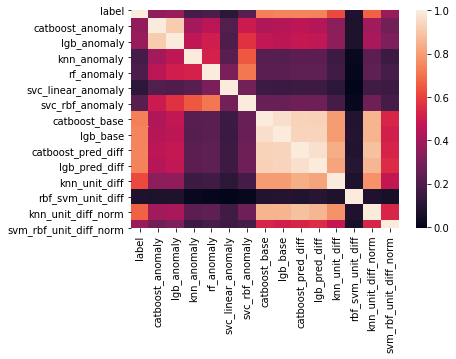

In [94]:
sns.heatmap(model_predictions_train.corr())

### Catboost

In [95]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1'
}

In [96]:
submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_cols)

In [97]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_cols)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9742479	test: 0.9773212	best: 0.9773212 (0)	total: 5.12ms	remaining: 5.12s
10:	learn: 0.9753496	test: 0.9780093	best: 0.9784977 (6)	total: 60.3ms	remaining: 5.42s
20:	learn: 0.9754598	test: 0.9785143	best: 0.9785143 (19)	total: 111ms	remaining: 5.19s
30:	learn: 0.9758440	test: 0.9783174	best: 0.9787070 (26)	total: 161ms	remaining: 5.03s
40:	learn: 0.9763575	test: 0.9783007	best: 0.9787070 (26)	total: 218ms	remaining: 5.11s
50:	learn: 0.9768381	test: 0.9783049	best: 0.9787070 (26)	total: 298ms	remaining: 5.54s
60:	learn: 0.9769789	test: 0.9780951	best: 0.9787070 (26)	total: 347ms	remaining: 5.35s
70:	learn: 0.9772651	test: 0.9784770	best: 0.9787070 (26)	total: 398ms	remaining: 5.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9787070045
bestIteration = 26

Shrink model to first 27 iterations.
Learning rate set to 0.057693
0:	learn: 0.9747317	test: 0.9770347	best: 0.9770347 (0)	total: 5.6ms	remaining: 5.59s
10:	learn: 0.97

In [98]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9566801564582378, 0.0055126559397819875, 0.948894783377542)

In [99]:
test_class

array([1, 1, 1, ..., 1, 1, 1])

### Extratrees

In [100]:
et_params = {
    'n_estimators':10,
    'max_depth':3,
    'random_state':0    
}

In [101]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = ExtraTreesClassifier(**et_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [102]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9556782184470816, 0.0055434506546343425, 0.9480106100795755)

## Knn classifier

In [103]:
knn_params = {
    'n_neighbors':15,
    'weights':'distance'    
}

In [104]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [105]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9553245178629268, 0.006389481919928317, 0.9464190981432361)